In [1]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Rectangle

In [2]:
driving_data_file_path = "../data-cleanup/merged-cleaned-csv/driving_data_merged_1_to_48.csv"
driving_data_original = pd.read_csv(driving_data_file_path)

In [3]:
# If we want to exclude participants, do it here
guess_excluded = [5,15,25,27,29]
diff_excluded = [10,14,16,32]
control_excluded = [34,42,45]

exclusion_list = guess_excluded + diff_excluded + control_excluded
#exclusion_list = []

# Remove all rows which are of participants who are in the exclusion_list
# .copy() is important to avoid warnings later, if .copy() not used and we modify driving_data, driving_data_original will be affected too!
driving_data = driving_data_original[~driving_data_original.user_id.isin(exclusion_list)].copy()

# Convert throttle position from [0,1] to [0,100]
driving_data["throttle_position"] *= 100

In [4]:
# Total number of participants
total_number_of_participants = len(driving_data.user_id.unique())

# Get a df with all unique ids and count the number of users in each group
unique_ids = driving_data.groupby(["evis_id", "user_id"], as_index=False).count() 
number_of_participants_diff = len(unique_ids[unique_ids["evis_id"] == "diff_and_cope1"])
number_of_participants_guess = len(unique_ids[unique_ids["evis_id"] == "guess_o_meter"])
number_of_participants_control = len(unique_ids[unique_ids["evis_id"] == "control_group"])

number_of_participants = pd.DataFrame(data={
    "diff_and_cope1":[number_of_participants_diff], 
    "guess_o_meter":[number_of_participants_guess], 
    "control_group":[number_of_participants_control],
    "total": [sum([number_of_participants_control, number_of_participants_diff, number_of_participants_guess])]}, 
    index=["N"])

number_of_participants

,diff_and_cope1,guess_o_meter,control_group,total
N,12,11,13,36


### Check fail/succeed ratios

In [5]:
# Group based on attempt, evis and user id.
each_user = driving_data.groupby(["attempt", "evis_id","user_id"], as_index=False)

# Create a new df with the last datapoint for each attempt
each_user_final_data = each_user.tail(1)

# See it as successful if they are less than 50m from the target
successful_distance = 8000

failed_attempts = each_user_final_data[each_user_final_data.distance_traveled < successful_distance]
successful_attempts = each_user_final_data[each_user_final_data.distance_traveled >= successful_distance]

successrate_df = successful_attempts.groupby(["attempt", "evis_id"]).count()[["user_id", "timestamp"]]
successrate_df["timestamp"] = failed_attempts.groupby(["attempt", "evis_id"]).count()
successrate_df = successrate_df.rename(columns={
  "user_id": "successful",
  "timestamp": "failed"
})

successrate_df["success rate %"] = successrate_df.apply(lambda x: x["successful"]/(x["successful"]+x["failed"])*100, axis=1)
successrate_df["N"] = successrate_df.apply(lambda x: x["successful"] + x["failed"], axis=1)

successrate_df

successful  failed  success rate %     N
attempt evis_id                                                 
1       control_group            6       7       46.153846  13.0
        diff_and_cope1           6       6       50.000000  12.0
        guess_o_meter            3       8       27.272727  11.0
2       control_group           11       2       84.615385  13.0
        diff_and_cope1          11       1       91.666667  12.0
        guess_o_meter            9       2       81.818182  11.0

In [6]:
# Some drivers are very close to making it the entire distance, should we count them as successes or not?*
last_data_point = driving_data.groupby(["attempt","user_id"], as_index=False).tail(1)
close_to_making_it = each_user_final_data[(each_user_final_data.distance_traveled < 8000) & (each_user_final_data.distance_traveled > 7800)]

for index, user in close_to_making_it.iterrows():
  print("ID:"+str(user.user_id) +", attempt: "+ str(user.attempt) + ", distance: " + str(user.distance_traveled) + ", EVIS: " + user.evis_id)

ID:8, attempt: 1, distance: 7999.301, EVIS: diff_and_cope1
ID:8, attempt: 2, distance: 7998.99365, EVIS: diff_and_cope1
ID:21, attempt: 2, distance: 7948.84375, EVIS: guess_o_meter
ID:28, attempt: 1, distance: 7990.323, EVIS: diff_and_cope1
ID:39, attempt: 1, distance: 7945.16162, EVIS: control_group


In [7]:
# Decide which distance interval to average over
distance_window_size = 50 # in meters

# Calculate which distance window the row should belong to
def assignDistanceWindow(distance):
    distance_window_index = round(distance / distance_window_size)
    return distance_window_size * distance_window_index

# Add a new column which stores the distance window the distance traveled fits in
driving_data["distance_window"] = driving_data["distance_traveled"].apply(assignDistanceWindow)

# The range estimate seen by the driver using the guess-o-meter & control group is truncated
driving_data["seen_range_estimate"] = driving_data["range_estimate"].apply(lambda x: int(x))

In [9]:
## Calculate mean and STD

## If we want to exclude the failed attempts when calculating mean and STD
exclude_failed_attempts = True
if exclude_failed_attempts:
  for index, row in failed_attempts.iterrows():
    id = row.user_id
    attempt = row.attempt
    driving_data = driving_data[~((driving_data.user_id == id) & (driving_data.attempt == attempt))]

# Get the average and std of each distance window for each user in each drivign attempt
average_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "distance_window"], as_index=False).mean()
std_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "distance_window"], as_index=False).std()

# Get the mean and std for each attempt in each group
average_groups = average_individual.groupby(["attempt", "evis_id", "distance_window"], as_index=False).mean()
std_groups = average_individual.groupby(["attempt", "evis_id", "distance_window"], as_index=False).std()

# Get the average road height for each distance window
road_elevation = average_groups[["distance_window", "road_elevation"]]
road_elevation = road_elevation.groupby(["distance_window"], as_index=False).mean()

In [10]:
# When removing all failed attempts, use this to see how many drivers are in each average calculation
nr_drivers = driving_data.groupby(["evis_id", "attempt", "user_id"]).tail(1).groupby(["evis_id", "attempt"]).count()
nr_drivers = nr_drivers[["user_id"]].rename(columns={"user_id":"N"})
nr_drivers.T

evis_id control_group     diff_and_cope1     guess_o_meter   
attempt             1   2              1   2             1  2
N                   6  11              6  11             3  9

## Plot group averages

In [11]:
variables_print_pretty = {
  "diff_and_cope1": "Diff & COPE1",
  "guess_o_meter": "Guess-o-meter",
  "control_group": "Control group",
  "speed": "Speed",
  "power_usage": "Power",
  "throttle_position": "Throttle"
}
variables_unit = {
  "speed": "[km/h]",
  "power_usage": "[kW]",
  "throttle_position": "[%]"
}
matplot_params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 10,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(matplot_params)

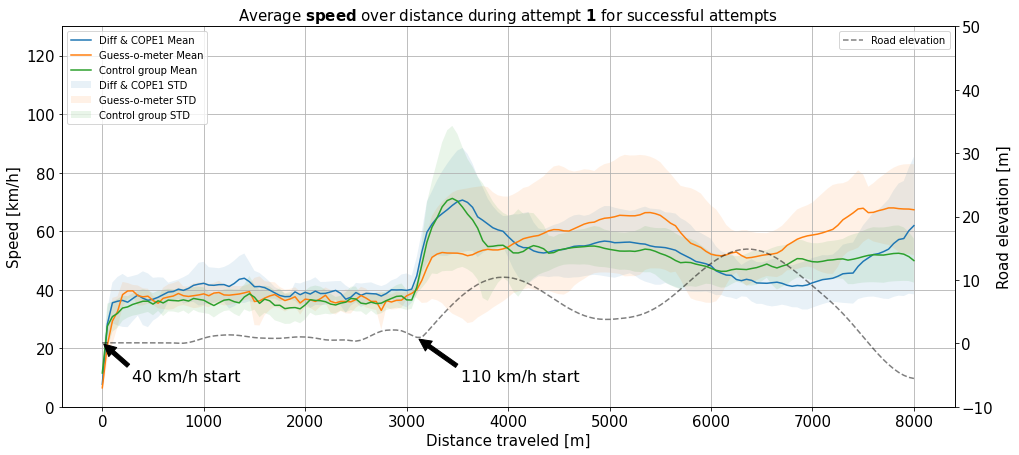

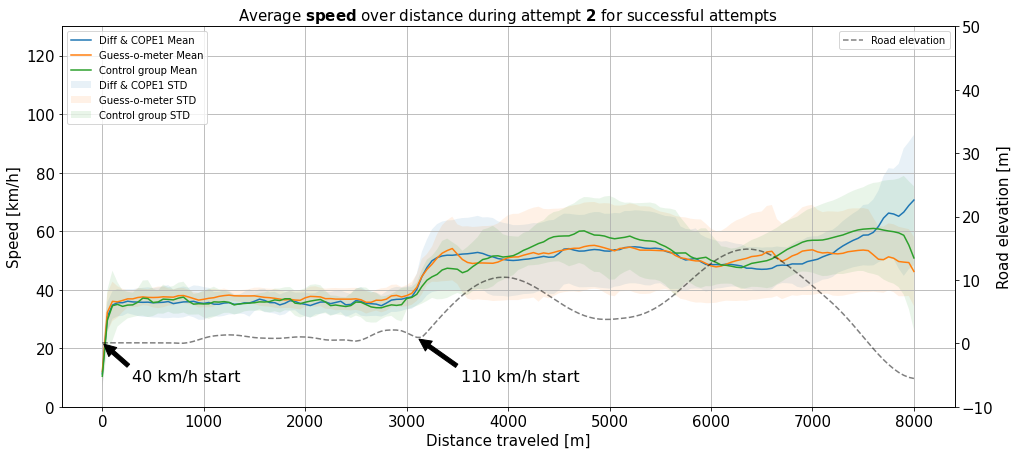

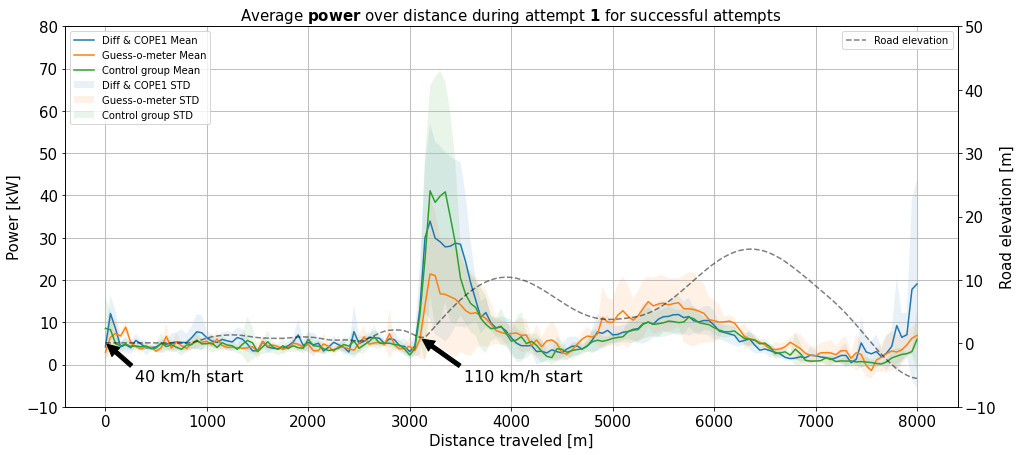

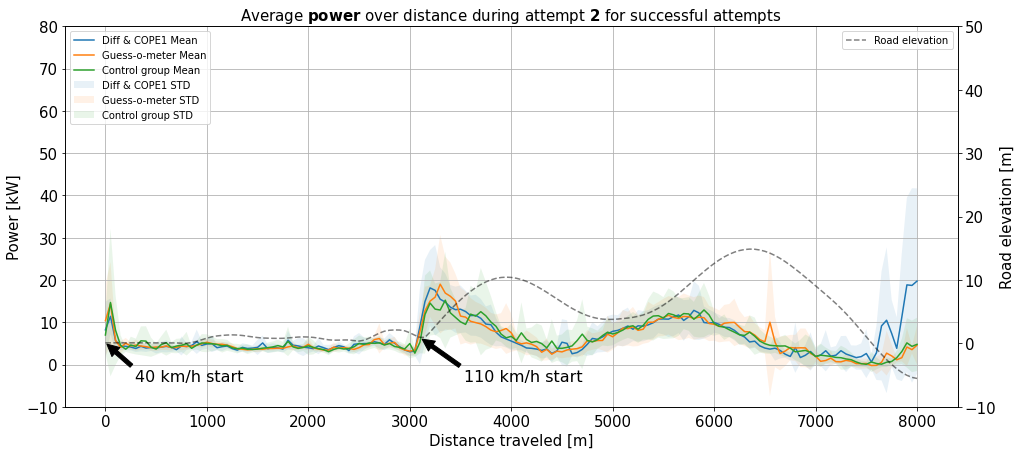

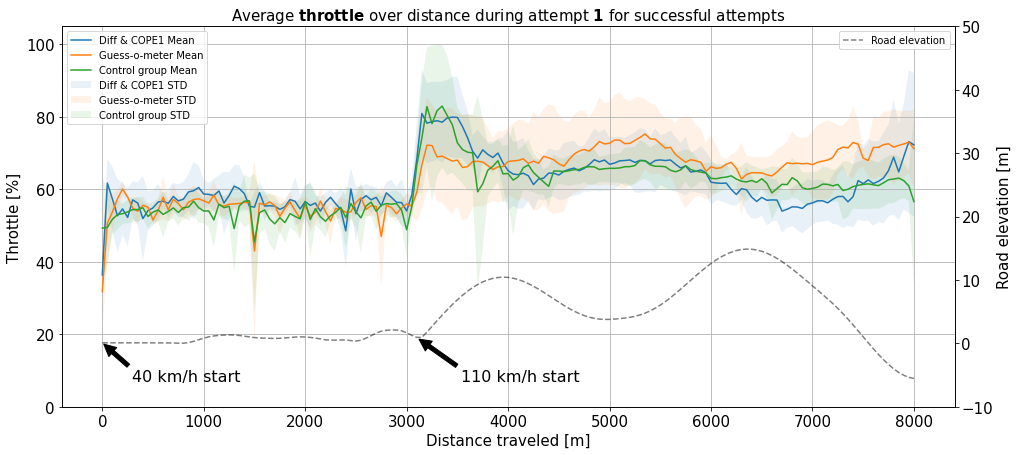

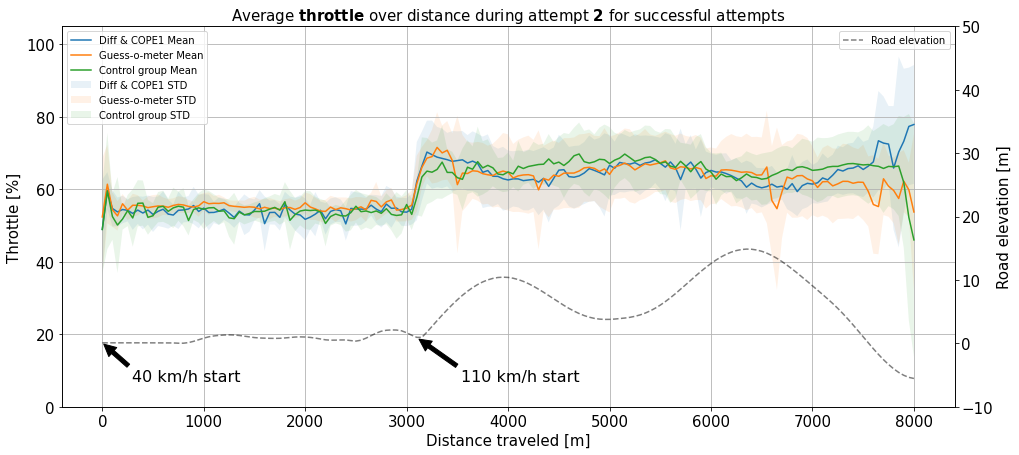

In [12]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]
  
  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean.distance_window, diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean.distance_window, guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean")

  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean.distance_window, control_group_mean[variable_to_plot], label="Control group Mean")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "diff_and_cope1")]
  plt.fill_between(
    diff_group_std.distance_window, 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha, label="Diff & COPE1 STD")

  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean.distance_window, 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha, label="Guess-o-meter STD")
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean.distance_window, 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha, label="Control group STD")
  
  # plot fails
  plt.gca().set_prop_cycle(None)
  
  if not exclude_failed_attempts:
    failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
    plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

    failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
    plt.scatter(failed_guess.distance_traveled, failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

    failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
    plt.scatter(failed_control_group.distance_traveled, failed_control_group[variable_to_plot], label="Control group failed attempts")

  # plot road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  # hlines at speed signs
  #road_evel_ax.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
  #road_evel_ax.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
  #road_evel_ax.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
  
  # Arrows pointing to speed signs
  road_evel_ax.annotate('40 km/h start', (0, road_elevation.road_elevation[0]),
            xytext=(0.2, 0.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
  road_evel_ax.annotate('110 km/h start', (3100, road_elevation.road_elevation[30]),
          xytext=(0.58, 0.1), textcoords='axes fraction',
          arrowprops=dict(facecolor='black', shrink=0.05),
          fontsize=16,
          horizontalalignment='right', verticalalignment='top')
  
  # Set figure title
  tb1 = r"$\bf{" + variables_print_pretty[variable_to_plot].lower() + "}$"
  tb2 = r"$\bf{" + str(attempt) + "}$"
  ax.set_title("Average " + tb1 + " over distance during attempt " + tb2 + " for successful attempts")
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  road_evel_ax.legend()
  ax.legend(loc="upper left")  
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])

  if False:
    title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_attempt_" + str(attempt) + "_arrow_speed_" + "excluded_ids_" + str(exclusion_list)
    plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
    #title = "sample_distance_"+str(distance_window_size)+"m"
    #plt.savefig("/home/steve/Pictures/figures/average distances/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
plotGroupAverage(variable, 1)
plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
plotGroupAverage(variable, 2)

## Highlight areas of interest  
Example of how we could highlight certain areas in the graph

In [ ]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(15,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]
  
  # Speed mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean.distance_window, diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean.distance_window, guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean")

  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean.distance_window, control_group_mean[variable_to_plot], label="Control group Mean")
  
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "diff_and_cope1")]
  plt.fill_between(
    diff_group_std.distance_window, 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha, label="Diff & COPE1 STD")

  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean.distance_window, 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha, label="Guess-o-meter STD")
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean.distance_window, 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha, label="Control group STD")
  
  # Fails
  plt.gca().set_prop_cycle(None)
  
  failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
  #plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

  failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
  #plt.scatter(failed_guess.distance_traveled, failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

  failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
  #plt.scatter(failed_control_group.distance_traveled, failed_control_group[variable_to_plot], label="Control group failed attempts")

    # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  #road_evel_ax.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
  #road_evel_ax.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
  #road_evel_ax.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
  
  # Alternative marker for where speed limit signs are
  road_evel_ax.annotate('40 km/h start', (0, road_elevation.road_elevation[0]),
            xytext=(0.2, 0.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
  road_evel_ax.annotate('110 km/h start', (3100, road_elevation.road_elevation[31]),
          xytext=(0.58, 0.1), textcoords='axes fraction',
          arrowprops=dict(facecolor='black', shrink=0.05),
          fontsize=16,
          horizontalalignment='right', verticalalignment='top')
  
  road_evel_ax.legend()

  
  
  tb1 = r"$\bf{" + variables_print_pretty[variable_to_plot].lower() + "}$"
  tb2 = r"$\bf{" + str(attempt) + "}$"

  ax.set_title("Average " + tb1 + " over distance during attempt " + tb2)
  
  ax.legend(loc="upper left")
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,90)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
    
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])

    
  rect = Rectangle((2900, 30), 900, 55, fill=False, linewidth=2)
  ax.add_patch(rect)  
  
  ax.text(0.375, 0.94, 'A',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=25,
        fontweight='bold')
  
  
  rect = Rectangle((7500, -5), 600, 60, fill=False, linewidth=2, linestyle="dashed")
  ax.add_patch(rect)  
  
  ax.text(0.891, 0.641, 'B',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes,
        fontsize=25,
        fontweight='bold')
  
  if True:
    title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_attempt_" + str(attempt) + "_highlighted_areas_3_" + "excluded_ids_" + str(exclusion_list)
    plt.savefig("/home/steve/Pictures/figures/average with excluded/" + title + ".png", dpi=200)
  
  
  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)

## Plot EVIS individually

In [ ]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, attempt, save_images):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(15,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]

  # Speed mean
  diff_cope_mean_1 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 1)]
  plt.plot(diff_cope_mean_1.distance_window, diff_cope_mean_1[variable_to_plot], label="Diff & COPE1 Mean Attempt 1")
  
  diff_cope_mean_2 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 2)]
  plt.plot(diff_cope_mean_2.distance_window, diff_cope_mean_2[variable_to_plot], label="Diff & COPE1 Mean Attempt 2")
   
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  for i in range(2):
    diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == i+1)]
    diff_group_std = std_groups[(std_groups.attempt == i+1) & (std_groups.evis_id == "diff_and_cope1")]
    plt.fill_between(
      diff_group_std.distance_window, 
      diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
      diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
      alpha=std_alpha, label="Diff & COPE1 STD attempt " + str(i+1))
  
  # Fails
  plt.gca().set_prop_cycle(None)

  for i in range(2):
    failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == i+1)]
    plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 fails attempt " + str(i+1))

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  title = "Average " + str(variable_to_plot) + " during attempt " + str(attempt_nr)
  plt.title(title)
  ax.legend(loc="upper left")
  #ax.set_ylim(0,130)
  road_evel_ax.legend()
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(str(variable_to_plot) + " [km/h]")

  if save_images:
    plt.savefig("/home/steve/Pictures/figures/" + title + ".png", dpi=200)

  plt.show()
  
  
save_images = False
variable = "speed"
plotIndividualAverages(variable, 1, save_images)
plotIndividualAverages(variable, 2, save_images)

## Plot each driver individually
Here I plot each user's first and second attempt in individual plots

In [ ]:
average_individual.groupby(["user_id"])

In [ ]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}

matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, save_images):
  variable_to_plot = variable
  
  counter = 0
  
  for id, data in average_individual.groupby(["user_id"]):
    fig, ax = plt.subplots(figsize=(15,7))
    
    evis = data["evis_id"].iloc[0] # Get which evis the driver is using
    attempt = data["attempt"].iloc[0] # Get which attempt
    
    a1 = data[data["attempt"] == 1]
    a2 = data[data["attempt"] == 2]
    
    plt.plot(a1.distance_window, a1[variable_to_plot] * 100, label="Attempt #1")
    plt.plot(a2.distance_window, a2[variable_to_plot] * 100, label="Attempt #2")
    
    # Road elevation
    ax_secondary = ax.twinx()
    ax_secondary.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.3)
    ax_secondary.set_ylim(-10, 50)
    ax_secondary.set_ylabel("Road elevation [m]")
    
    ax_secondary.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
    ax_secondary.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
    ax_secondary.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
        
    #tb1 = r"$\bf{" + str(variable_to_plot.capitalize()) + "}$"
    tb1 = r"$\bf{" + "Throttle" + "}$"
    tb2 = r"$\bf{" + "distance" + "}$"
    tb3 = r"$\bf{" + str(id) + "}$"
    tb4 = r"$\bf{" + variables_print_pretty[evis] + "}$"
    if(evis == "control_group"):
      evis_temp = variables_print_pretty[evis].split(" ")
      tb4 = r"$\bf{" + evis_temp[0] + "}$" + " " + r"$\bf{" + evis_temp[1] + "}$"
    
    ax.set_title(tb1 + " over " + tb2 + " for user with id " + tb3 + " using EVIS " + tb4)
    
    ax.grid(True)
    ax.set_xlabel("Distance traveled [km/h]")
    ax.set_ylabel("Throttle [%]")
    ax.set_ylim(0,105)
    #ax.set_ylim(0,1)
    ax.legend(loc="upper left", framealpha=1).set_zorder(200)
    ax_secondary.legend(loc="lower left", framealpha=1).set_zorder(100)
    plt.tight_layout()
    
    ax.set_zorder(1)
    ax_secondary.set_zorder(2)
    
    if True:
      file_name = str(id) + "_" + str(evis) + "_" + str(variable_to_plot)
      plt.savefig("/home/steve/Pictures/figures/individual_attempts/throttle/" + file_name + ".png", dpi=200)

    
    counter += 1

    #if counter > 2:
    #  return
  
  
save_images = False
variable = "throttle_position"
#plotIndividualAverages(variable, save_images)


In [ ]:
#last_data_point = each_user.tail(1)[["user_id", "evis_id", "attempt", "distance_traveled"]]
#last_data_point["succeeded"] = last_data_point["distance_traveled"] >= 8000
#last_data_point.to_csv("last.csv",index=False)

## Check how may failed with a particular throttle position

In [ ]:
#for index, row in failed_attempts[failed_attempts.throttle_position >= 80].iterrows():
#  print("user id: " + str(row.user_id) + ", attempt: " + str(row.attempt) + ", evis: " + row.evis_id + ", throttle: " + str(int(row.throttle_position*10)/10) + "%")

throttle_percentage = 90
evis = "guess_o_meter"
attempt = 1
a1g = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position < throttle_percentage)]
a1gt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2g = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a2gt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

evis = "diff_and_cope1"
attempt = 1
a1d = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a1dt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2d = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a2dt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

evis = "control_group"
attempt = 1
a1c = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a1ct = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2c = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)]
a2ct = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]


throttle_percentage = pd.DataFrame({
  "evis": ["guess_o_meter", "guess_o_meter", "diff_and_cope1", "diff_and_cope1", "control_group", "control_group"],
  "attempt": [1, 2, 1, 2, 1, 2],
  "throttle < "+str(throttle_percentage)+"%": [len(a1g), len(a2g)] + [len(a1d), len(a2d)] + [len(a1c), len(a2c)], 
  "throttle >= "+str(throttle_percentage)+"%": [len(a1gt), len(a2gt)] + [len(a1dt), len(a2dt)] + [len(a1ct), len(a2ct)]
})

#throttle_percentage = throttle_percentage.groupby(["evis", "attempt"])
throttle_percentage = throttle_percentage.set_index(["evis", "attempt"])


throttle_percentage.iloc[:,0] = throttle_percentage.iloc[:,0] 

throttle_percentage["% over"] = (throttle_percentage.iloc[:,1] / (throttle_percentage.iloc[:,1] + throttle_percentage.iloc[:,0]))*100
throttle_percentage["% over"] = throttle_percentage["% over"].round(1)

throttle_percentage.T